# EIMS Data
This script will read in the individual EIMS data files from the given directory and compile/prase the data for the model.

In [1]:
source('source.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table


Loading required package: ncdf4
Loading required package: R.matlab
Warning message:
"package 'R.matlab' was built under R version 3.4.3"R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen

Loading required package: openxlsx
Warning message:
"package 'openxlsx' was built under R version 3.4.3"Loading required package: RColorBrewer
Loading required package: compiler
Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.4.3"Loading required package: geosphere
Warning message:
"package 'geosphere' was built under R version 3.4.3"Loading required package: readxl
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"there is no package called 'readxl'"Loading required package: data.table
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logica

# File Input

First we need to set the directory and file name criteria of the data to load. We also set the date-time format that the parser will be expecting.

In [2]:
input.dir = './Raw Data/EIMS/'
dt.format = "%m/%d/%y %I:%M %p"

## Generate list of files in the directory
file.list = list.files(input.dir)

## split file.list into usable lists
file.list.nu = file.list[grepl('not usable', file.list)] # not usable
file.list.2 = file.list[grepl('corr.txt', file.list)] # usable

## Print total number of files in each category
print(paste('Number of files in file.list:', length(file.list)))
print(paste('Number of files in file.list.2:', length(file.list.2)))
print(paste('Number of files in file.list.nu:', length(file.list.nu)))


[1] "Number of files in file.list: 177"
[1] "Number of files in file.list.2: 67"
[1] "Number of files in file.list.nu: 5"


In [7]:
## Read in first data file and configure formatting around it
data = read.csv(paste0(input.dir, file.list.2[40]), sep='\t')
data$time = strptime(data$time, format = dt.format, tz='GMT')

# Main Functions

These functions will do the heavy lifting for the EIMS preparation. The __avg.eims()__ generates the average of N minutes of samples while __filter.eims()__ goes QC type of work by removing high/low pressure samples and handles missing values.

In [12]:
## Average
avg.eims = function(x, N) {
    i = 1
    
    while (i < nrow(x)) {
        dt = as.numeric(difftime(x$time, x$time[i], unit='mins'))
        l = which(dt >= 0 & dt < N)
        
        ## Calculate the mean of the relevant columns, removing na's
        x[i, 3:ncol(x)] = apply(x[l, 3:ncol(x)], 2, function(x) {mean(x, na.rm = TRUE)})
        
        if (max(dt[l], na.rm = TRUE, 0) < N / 2) {
            x$Flag[i] = 3
        }
    
        if (length(l) > 1) {
            l = l[l != i]
            if (length(l) > 1) {
                x = x[-l,]
            }
        }
        i = i + 1
    }
    x
}

## Prepare filter function
filter.eims = function(x) {
    x$Flag = 1
    
    ## Remove entries where flow not within 5% of 100
    x$Flag[x$flow > 105 | x$flow < 95] = 3 # Reject
    x$Flag[x$O2.Ar > 35 | x$O2.Ar < 22] = 3 # Reject
    
    ## Remove first 2 minute (safer to remove bad data than to keep it)
    l = which(as.numeric(difftime(x$time, x$time[1], unit='mins'))^2 < 2)
    x$Flag[l] = 3 # Reject
    
    ## Remove last 2 minute (safer to remove bad data than to keep it)
    l = which(as.numeric(difftime(x$time, x$time[nrow(x)], unit='mins'))^2 < 2)
    x$Flag[l] = 3 # Reject
    
    ## find all valve switches and remove all entries within a miute of it.
    l = which(diff(x$Valve) != 0)
    for (i in l) {
        dt = abs(as.numeric(difftime(x$time[i], x$time, unit='mins')))     
        x$Flag[which(dt <= 1)] = 3 # Reject
    }
    ## Remove NA O2Ar entries
    x$Flag[is.na(x$O2.Ar)] = 3 # Reject
    
    x$Flag[x$Valve == 2] = 2 # Calibration
    #x$Flag[is.na(x$Valve)] = 3 # Reject unknown valve
    
    x
}

## Check the filter and avg functions

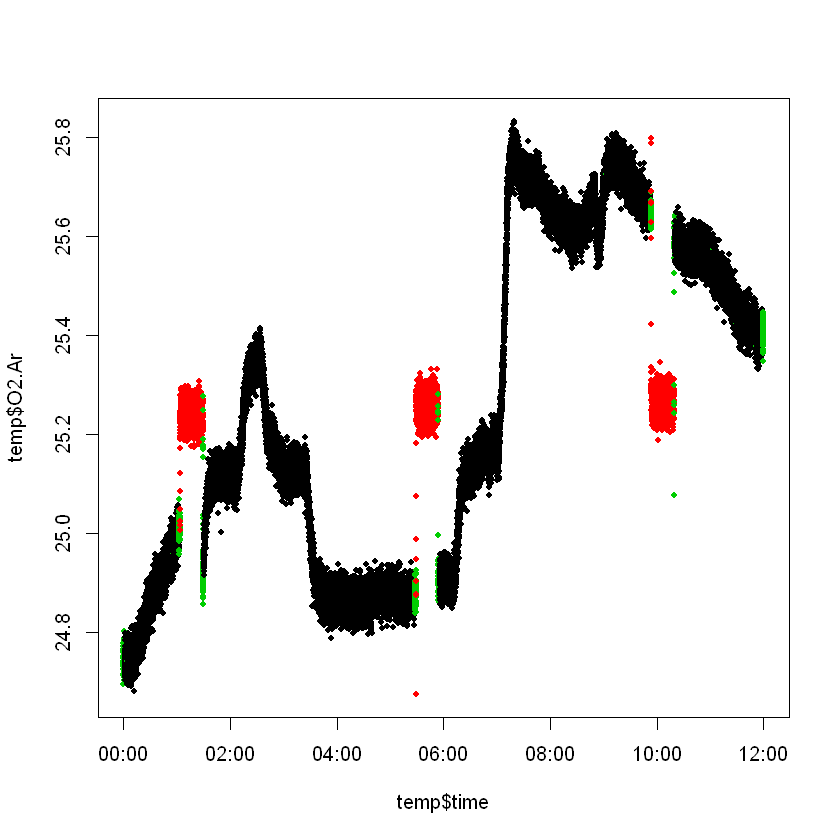

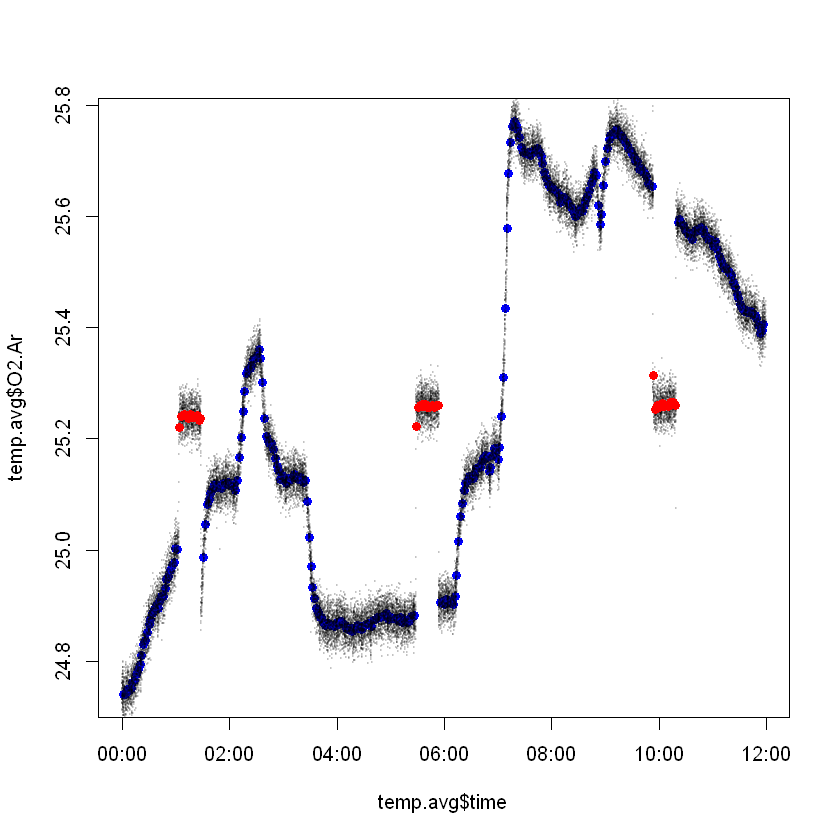

In [13]:
temp = data
temp = filter.eims(temp)
temp.avg = avg.eims(temp[temp$Flag == 1,], 2)
temp.cal = avg.eims(temp[temp$Flag == 2,], 2)

plot(temp$time, temp$O2.Ar, col = temp$Flag, pch=20)
plot(temp.avg$time, temp.avg$O2.Ar, col = "blue", pch=16)
points(temp$time, temp$O2.Ar, col = "#00000020", pch=20, cex=0.3)
points(temp.cal$time, temp.cal$O2.Ar, col = "red", pch=20, cex=1.5)

In [14]:
read.eims = function(valve = 1, input.dir, file.list, N = 2, verbose = FALSE, template = data, make.img = FALSE) {
    ## Create template data structure to add new entries to:
    dat = template[1,] # valve = 1
    dat$Flag = 0
    
    for (i in file.list) {
        
        #### load file and parse the time and filter the values
        data = read.csv(paste0(input.dir, i), sep='\t')
        data$time = strptime(data$time, format = dt.format, tz='GMT')
        data$Flag = 0
        
        ## Filter
        data = filter.eims(data)
        
        if (make.img) {
            cols = c('black', 'orange', 'red')
    
            png(file = paste0('Output/EIMS/', i, '.png'))
            try({plot(data$time, data$O2.Ar, col=cols[data$Flag], pch=20, ylab='O2/Ar', xlab='', main=i, cex=0.2)})
            dev.off()
        }
        
        ## Verbose
        if (verbose) { print(paste("Loaded file:", i)) }
        
        #### determine valve  
        l = which(data$Valve == valve)
        temp = avg.eims(data[l,], N)
        #temp = data[l,]
        
        if (length(names(temp)) == length(names(dat))) {
            ## Do the column names match?
            names(temp) = names(dat) # Force colname match (dangerous), but will check that lengths are the same
            dat = rbind(dat, temp)
            
            if (verbose) { print(paste('  Added', nrow(temp),'to valve 1.')) }
            
        }
        else {warning(i)}
    }


    ## Remove the first row used to initiate the table
    dat = dat[-1,]
    dat = dat[,-c(13, 14, 15, 23, 24, 25)]
    
    dat
}

## Run the parser
This will initialize the parser for valve = 1 (sampling) and then valve = 2 (calibration). Included in this is the ___filter.eims()___ and ___take.avg()___ functions.

__NB This will take a while...__

In [15]:
data.v1 = read.eims(1, input.dir, file.list.2, N = 2, verbose = FALSE, template = data, make.img = TRUE)

Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in 

In [16]:
data.v2 = read.eims(2, input.dir, file.list.2, N = 2, verbose = FALSE, template = data, make.img = FALSE)

In [17]:
## Also, correct the time since the year is not actually 2021...
data.v1$time = data.v1$time - 4 * 365.25 * 86400 - 86400
data.v2$time = data.v2$time - 4 * 365.25 * 86400 - 86400

## Remove NA O2:Ar values
data.v1 = data.v1[which(!is.na(data.v1$O2.Ar)),]
data.v2 = data.v2[which(!is.na(data.v2$O2.Ar)),]

## Number of entries, do they seem right?
nrow(data.v1)
length(which(data.v1$Flag == 3))
nrow(data.v2)
length(which(data.v2$Flag == 3))

[1] 12446

[1] 833

[1] 1404

[1] 28

## Review results

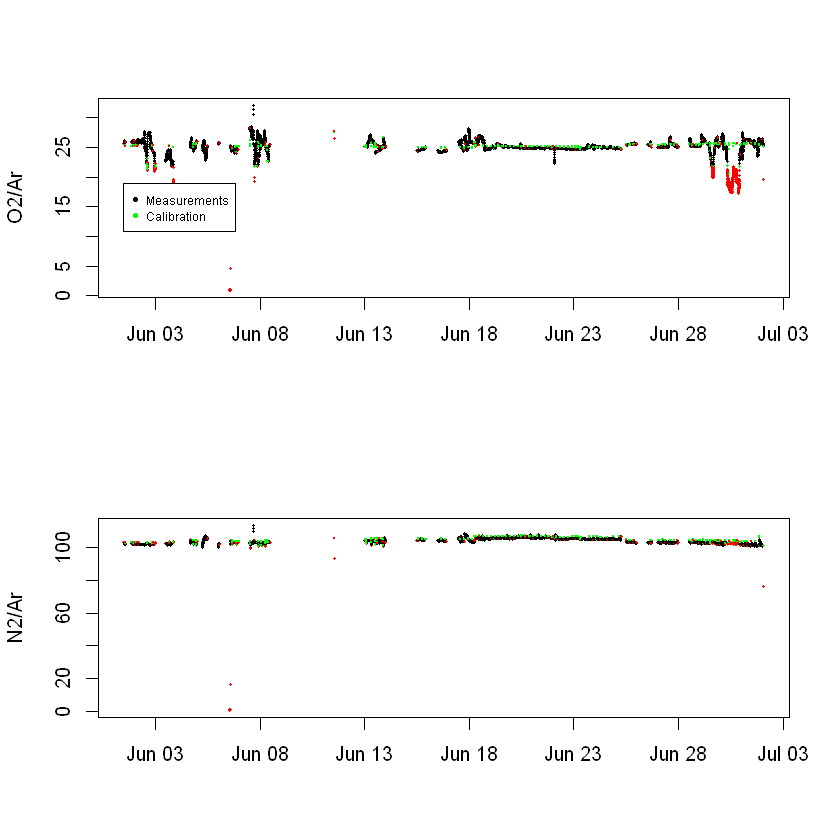

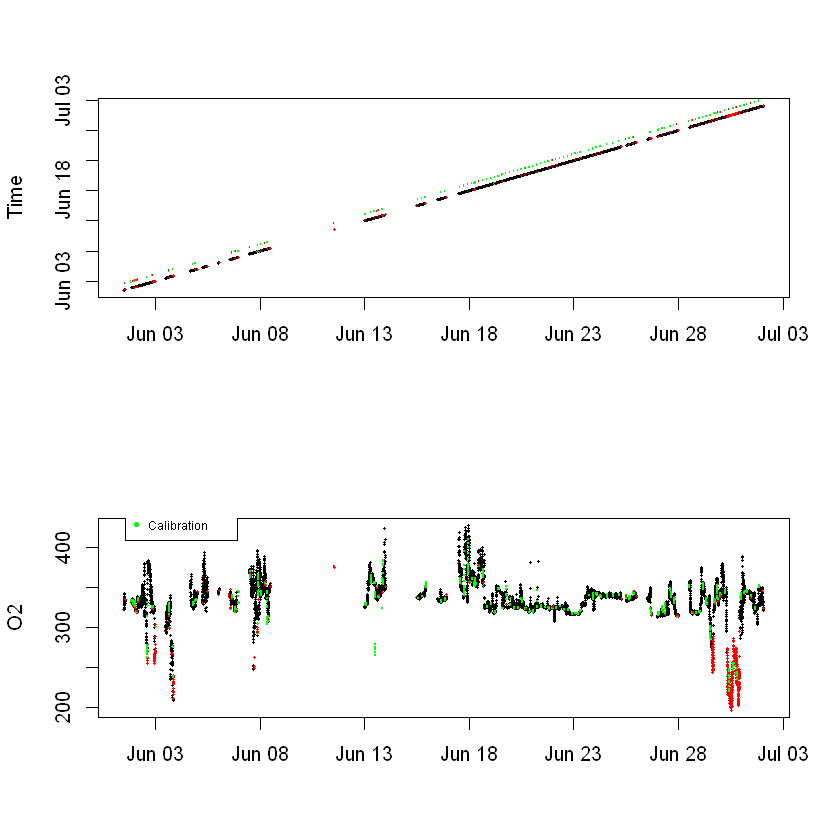

In [22]:
#pdf('./Output/Generate-EIMS-review1.pdf')

par(mfrow=c(2,1))
cols = c('black', 'green', 'red')

plot(data.v1$time, data.v1$O2.Ar, pch=16, cex=0.3, ylab='O2/Ar', xlab='', col=cols[data.v1$Flag])
points(data.v2$time, data.v2$O2.Ar, pch=16, cex=0.2, col=cols[data.v2$Flag])

legend(data.v1$time[1], 19, c('Measurements', 'Calibration'), col=c('black', 'green'), pch=16, cex=0.6)

plot(data.v1$time, data.v1$N2.Ar, pch=16, cex=0.3, ylab='N2/Ar', xlab='', col=cols[data.v1$Flag])
points(data.v2$time, data.v2$N2.Ar, pch=16, cex=0.2, col=cols[data.v2$Flag])

plot(data.v1$time, data.v1$time, pch=16, cex=0.3, ylab='Time', xlab='', col=cols[data.v1$Flag])
points(data.v2$time, data.v2$time+86400, cex=0.2, col=cols[data.v2$Flag])

plot(data.v1$time, data.v1$O2..uM., pch=16, cex=0.3, ylab='O2', xlab='', col=cols[data.v1$Flag])
points(data.v2$time, data.v2$O2..uM., pch=16, cex=0.2, col=cols[data.v2$Flag])

legend(data.v2$time[1], 470, c('Measurements', 'Calibration'), col=c('black', 'green'), pch=16, cex=0.6)

#dev.off()

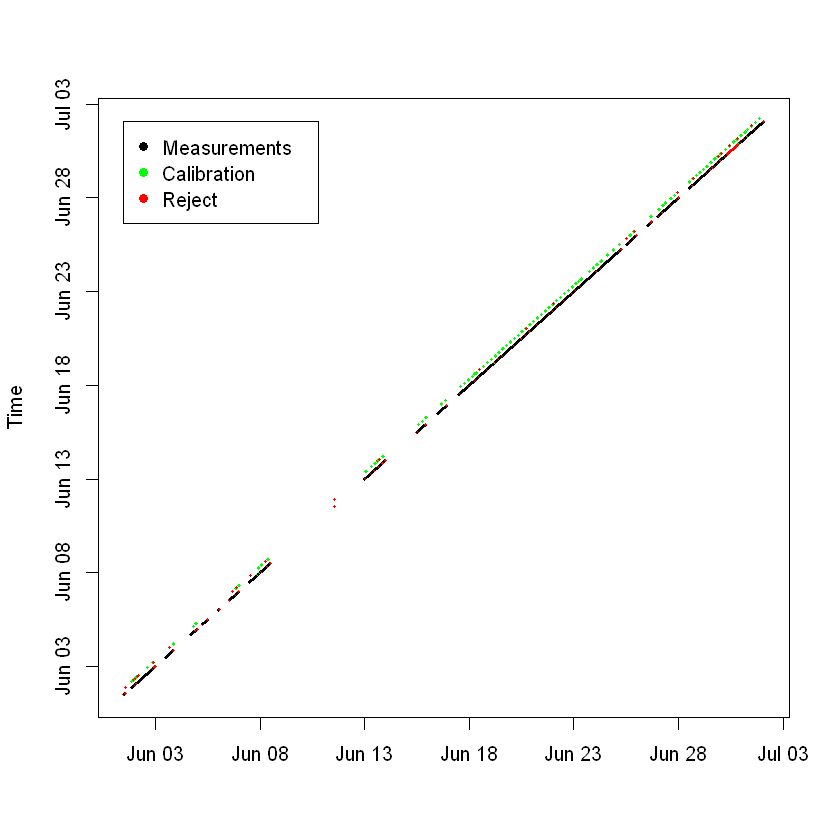

In [23]:
#pdf('./Output/Generate-EIMS-review2.pdf')

plot(data.v1$time, data.v1$time, pch=16, cex=0.3, ylab='Time', xlab='', col = cols[data.v1$Flag])
points(data.v2$time, data.v2$time+86400/3, pch=16, cex=0.3, col = cols[data.v2$Flag])
legend(data.v1$time[1], data.v1$time[nrow(data.v1)], c('Measurements', 'Calibration', 'Reject'),
       col=cols, pch=16)

#dev.off()

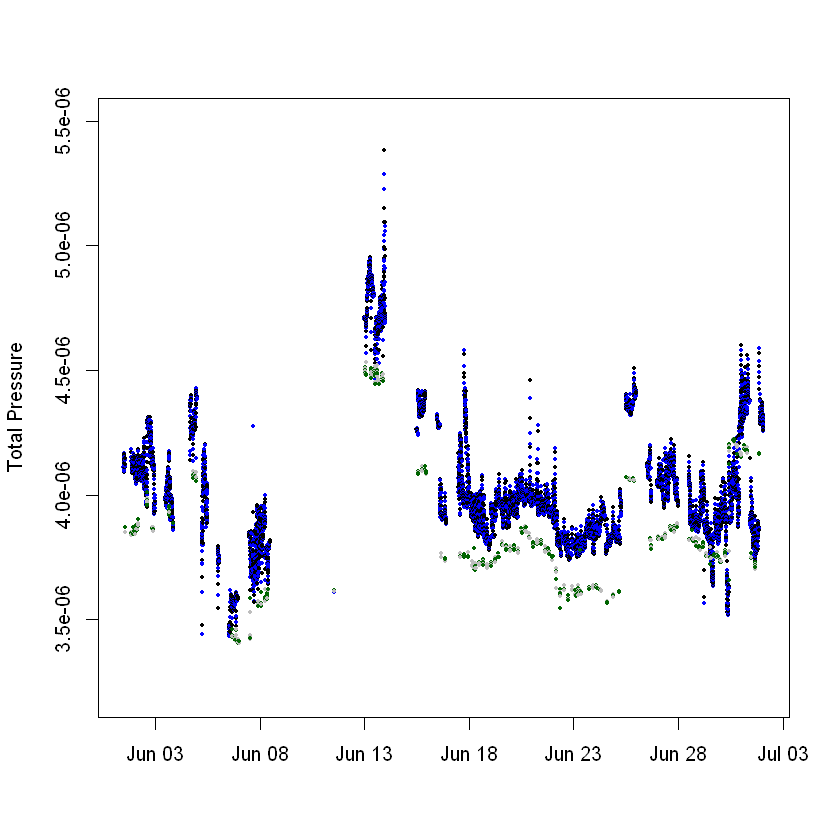

In [24]:
plot(data.v1$time, data.v1$TP, col='white', ylim=c(3.2e-6, 5.5e-6), ylab='Total Pressure', xlab='')

col = c('Black', 'blue', 'grey', 'dark green')

for (i in 1:length(unique(data.v1[,1]))) {
    l = which(data.v1[,1] == unique(data.v1[,1])[i])
    points(data.v1$time[l], data.v1$TP[l], col=col[i %% 2 + 1], pch=20, cex=0.6)
}

for (i in 1:length(unique(data.v2[,1]))) {
    l = which(data.v2[,1] == unique(data.v2[,1])[i])
    points(data.v2$time[l], data.v2$TP[l], col=col[i %% 2 + 3], pch=20, cex=0.6)
}


# Save

In [25]:
## Save the data
eims = list(sample = data.v1, cal = data.v2)
save(eims, file='./RStates/EIMS.2min.2min.rdata')

## Optional
write.csv(data.v1, './Input Data/EIMS-Valve1.2min.csv')
write.csv(data.v2, './Input Data/EIMS-Valve2.60min.csv')

In [31]:
load('./RStates/EIMS.2min.2min.rdata')

In [32]:
par(mfrow=c(3,1))

#pdf('Output/EIMS-24H Plots.pdf')

eims = eims$sample[!is.na(eims$sampletime),]
dt = floor(as.numeric(difftime(eims$time, min(eims$time), units='days')))
dt2 = floor(as.numeric(difftime(eims$time, min(eims$time, na.rm = TRUE), units='days')))

for (i in 1:floor(as.numeric(difftime(max(eims$time), min(eims$time), units='days')))) {
    k = which(dt < i & dt >= i-1)
    if(length(k) < 1) {
        k = 1
    }
    k2 = which(dt2 < i & dt2 >= i-1)
    plot(eims$time[k], eims$O2.Ar[k], pch=20, main=paste('Day -', i), xlab='', ylab='O2/Ar', ylim=c(20,30))
    points(eims$time[k2], eims$O2.Ar[k2], pch=20, col='red')
}
#dev.off()

Warning message in is.na(eims$sampletime):
"is.na() applied to non-(list or vector) of type 'NULL'"Warning message in min.default(structure(numeric(0), class = c("POSIXct", "POSIXt":
"no non-missing arguments to min; returning Inf"Warning message in min.default(structure(numeric(0), class = c("POSIXct", "POSIXt":
"no non-missing arguments to min; returning Inf"Warning message in max.default(structure(numeric(0), class = c("POSIXct", "POSIXt":
"no non-missing arguments to max; returning -Inf"Warning message in min.default(structure(numeric(0), class = c("POSIXct", "POSIXt":
"no non-missing arguments to min; returning Inf"

ERROR: Error in 1:floor(as.numeric(difftime(max(eims$time), min(eims$time), units = "days"))): result would be too long a vector


---
# Damaged/Unusable data file recovery

In [ ]:
2

In [34]:
## Create template data structure to add new entries to:
data.v3 = data[1,] # valve = 1
data.v4 = data[1,] # valve = 2
N = 2

for (i in file.list.nu) {
    ## load file and parse the time
    data = read.csv(paste0(input.dir, i), sep='\t')
    data$time = strptime(data$time, format = dt.format, tz='')
    
    ## determine valve = 1 
    l = which(data$Valve == 1)
    temp = filter.eims(data[l,])
    temp = avg.eims(temp, N)
    
    if (length(names(temp)) == length(names(data.v1))) {
        names(temp) = names(data.v3) # Force colname match (dangerous), but will check that lengths are the same
        data.v3 = rbind(data.v3, temp)
    } else {
        print(i)
    }
    
    ## determine valve = 2
    l = which(data$Valve == 2)
    temp = filter.eims(data[l,])
    temp = avg.eims(temp, N)
    
    if (length(names(temp)) == length(names(data.v4))) {
        names(temp) = names(data.v4) # Force colname match (dangerous), but will check that lengths are the same
        data.v4 = rbind(data.v4, temp)
    } else {
        print(i)
    }
    if (length(data$valve) > 1) {
        print(paste("Lower case Valve issue:", i))
    }
}


## Remove the first row used to initiate the table
data.v3 = data.v3[-1,]
data.v4 = data.v4[-1,]
data.v3 = data.v3[,-c(1, 13, 14, 15, 23, 24, 25)]
data.v4 = data.v4[,-c(1, 13, 14, 15, 23, 24, 25)]

[1] "2017-0603-2102 MID-valve corr not usable.txt"
[1] "2017-0603-2102 MID-valve corr not usable.txt"
[1] "2017-0604-0000 MID-valve corr - not usable.txt"
[1] "2017-0604-0000 MID-valve corr - not usable.txt"
[1] "2017-0604-0448 MID-valve corr not usable.txt"
[1] "2017-0604-0448 MID-valve corr not usable.txt"


ERROR: Error in `$<-.data.frame`(`*tmp*`, "Flag", value = 1): replacement has 1 row, data has 0
